In [61]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import statsmodels
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
import seaborn
import dateutil
from datetime import datetime
import math
import plotly.graph_objects as go
import plotly.express as px
import math
import functions.functions as base_fx
import functions.portfolio_functions as portfolio_fx
import functions.algorithms as algos
import importlib

In [62]:
importlib.reload(base_fx)
importlib.reload(portfolio_fx)
importlib.reload(algos)

<module 'functions.algorithms' from '../functions/algorithms.py'>

In [124]:
#symbols = ['EURJPY.FOREX', 'GBPJPY.FOREX']
#symbols = ['LUV.US','GD.US']
symbols = ['RDSA.LSE','BP.LSE', 'CVX']
#symbols = ['CL.COMM','GLEN.LSE','XOM.US','RDSA.LSE','ENI.MI',
  #           'PSX.US','BP.LSE']



# Get Data

In [125]:
quotes = pd.DataFrame()
#start = '2011-06-1' ## Starts with non-correlated period (drops 40% at the start)
start = '2010-01-1'
end = '2020-05-25'

In [126]:
for s in symbols:
    print(s)
    endpoint = f'https://eodhistoricaldata.com/api/eod/{s}?from={start}&to={end}&api_token={API_KEY}&interval=d&fmt=csv'
    df = pd.read_csv(endpoint)
    df = df[df['Adjusted_close'] > 0]
    #print(df.head(1))
    if len(quotes) == 0:
        quotes['Date'] = df['Date']
        quotes[s] = df['Adjusted_close']
    else:
        new_df = pd.DataFrame()
        new_df['Date'] = df['Date']
        new_df[s] = df['Adjusted_close']
        quotes = quotes.merge(new_df, how="inner", on="Date")
    #print(quotes)
#print(quotes.tail(20))

RDSA.LSE
BP.LSE
CVX


In [127]:
old_quotes = quotes
#quotes=old_quotes

#print(quotes)


In [128]:
quotes = quotes.dropna()
quotes = quotes.reset_index()
quotes['Date'] = pd.to_datetime(quotes['Date'])
quotes = quotes.set_index('Date')
#quotes = quotes[quotes.index > dateutil.parser.parse("2020-03-01")]
#print(quotes)

In [129]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

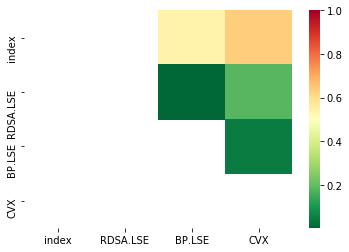

[('RDSA.LSE', 'BP.LSE'), ('BP.LSE', 'CVX')]


In [130]:
data = quotes
scores, pvalues, pairs = find_cointegrated_pairs(data)
m = [0,0.2,0.4,0.6,0.8,1]
seaborn.heatmap(pvalues, xticklabels=data.columns, 
                yticklabels=data.columns, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.80)
                )
plt.show()
print(pairs)


# Params

In [171]:
symbol1 = 'RDSA.LSE'
symbol2 = 'BP.LSE'

In [172]:
s1_normalized = base_fx.normalize(S1)
s2_normalized = base_fx.normalize(S2)
#print(s1_normalized)
portfolio_fx.plot_objects([{'label': 'S1', 'value': s1_normalized}, {'label': 'S2', 'value': s2_normalized}])

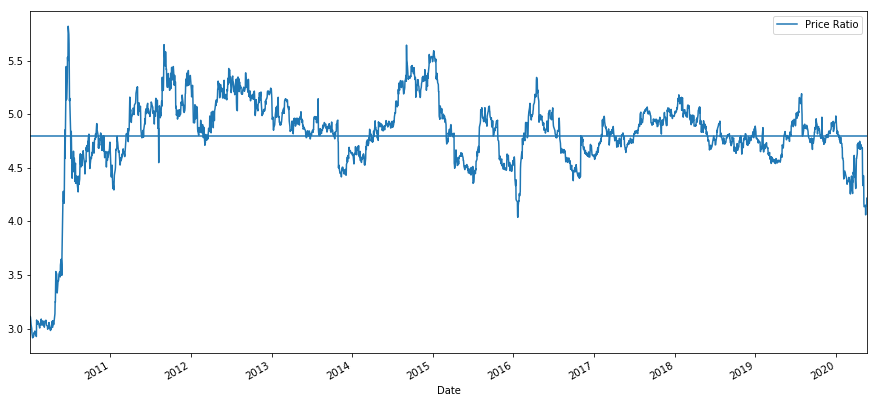

In [173]:
S1 = quotes[symbol1]
S2 = quotes[symbol2]

score, pvalue, _ = coint(S1, S2)
ratios = S1 / S2
ratios.plot(figsize=(15,7))
plt.axhline(ratios.mean())
plt.legend(['Price Ratio'])
plt.show()

In [186]:
# Indicators
macd_fast_points = 1
macd_slow_points = 2
max_leverage = 2

# Could be changed
mavg_1 = 5 # default 5
mavg_2 = 40 #default 60

## Optimize trading limits looking at zscore
limit = 0.75 #default 1
exit_limit = 0.4 #default -.75
leverage_limit = 0.9

## Optimize these with bruteforce
vol_interval = 30
vol_peak_period = 365 # 1 year
vol_mean_peak_period = 60 # 2 months
coint_limit = 2## change this for higher returns with more risk
coint_period = 365

def get_settings():
    return {
        'symbol1': symbol1,
        'symbol2': symbol2,
        'mavg_1' : mavg_1,
        'mavg_2': mavg_2,
        'macd_fast_points': macd_fast_points,
        'macd_slow_points': macd_slow_points,
        'vol_interval': vol_interval,
        'vol_peak_period': vol_peak_period,
        'vol_mean_peak_period': vol_mean_peak_period,
        'limit': limit,
        'leverage_limit': leverage_limit,
        'exit_limit': exit_limit,
        'max_leverage': max_leverage,
        'coint_limit': coint_limit,
        'coint_period': coint_period,
        'sl_limit': -0.03
    }

In [190]:
importlib.reload(base_fx)
importlib.reload(portfolio_fx)
importlib.reload(algos)
settings = get_settings()
portfolio, mavg_zscore = algos.pair_trade_with_zscore_limit_and_sl(settings, quotes)

0.0
0.02664492471316171
0.0517244364259728
Trigger SL on  s2: 2010-04-06 00:00:00 -0.07346668523823041
0.05562390833103725
0.03056218757619167
0.061983506251560794
0.07824520703462134
0.07205854487754815
0.1008864010030277
0.09284833141379112
0.09910500959898716
0.08894522479688449
0.11852565757437139
0.10036032428899055
0.07403276730986086
0.09825372182536407
0.09382798190563957
0.1098369745653387
0.1599240689566055
0.13610312404439373
0.1635907280031308
0.08609140209870203
0.042076189490537264
0.011023698416863237
-0.024586338705979482
0.010753773237406339
0.001429015655947552
-0.014371268023746664
0.017437243113153755
-0.021310506832827647
-0.009951458423344217
0.0027101559300946043
-0.03410545772069695
Trigger SL on s1: 2010-05-19 00:00:00 -0.03410545772069695
0.0
0.008711248708277886
Trigger SL on  s2: 2010-08-09 00:00:00 -0.034794442965160766
0.013564190272237209
-0.03175901272774895
Trigger SL on s1: 2010-08-11 00:00:00 -0.03175901272774895
0.0
0.005110686774000728
0.00030678501

0.007281623754007427
0.019903134430572678
0.0
0.006935077141902557
0.004161046285141579
0.014794138074925467
0.0036985691767881246
0.01803050740781309
0.0
-0.0013762680927054127
0.004357758177502169
0.020871531002826904
Trigger SL on  s2: 2014-01-27 00:00:00 -0.03606132996995115
0.02591738883889283
0.024999853851896514
0.014908138179764996
0.035091707075184386
0.03899093847371171
0.046330049184854616
0.04197242855850858
0.03486227174675183
0.03623847106387912
0.0341743096393442
0.016743070602601273
0.018099737655557502
0.01136502672447015
0.013919626796203177
-0.006285056201682959
-0.012787649556792902
-0.019754684390591803
-0.02927673194959146
-0.032295704724435215
Trigger SL on s1: 2014-02-24 00:00:00 -0.032295704724435215
0.0
-0.007933269770072915
-0.02939834188747259
-0.0214656248814582
-0.010732605154207153
Trigger SL on  s2: 2014-03-20 00:00:00 -0.037713571623031905
-0.027998605099897933
-0.013999578931978451
-0.031731558979130714
Trigger SL on s1: 2014-03-25 00:00:00 -0.03173155

0.36547785437666236
0.36746237421221095
0.35605287972087796
0.3481158400747333
0.335714085665626
0.33918641054880827
0.35406874977134817
0.32380878612042174
0.37440702397857506
0.34414732025166095
0.34662764514108124
0.3555566847809877
0.3099189667396687
0.28362765287382063
0.3158720063982896
0.3158720063982896
0.311407291635327
0.31736020133194165
0.33621041056752277
0.3629977894112546
0.3069429667583832
0.32926563083915217
0.3451394502074292
0.335714085665626
0.3689501792598442
0.35010022994827583
0.34662764514108124
0.2806515229305291
0.2816432630002781
0.2548564040045713
0.21318720578632444
0.19681706151615108
0.20028938639933314
0.21021068595701364
0.2136831408022022
0.20128151635510094
0.18193524214163603
0.20028938639933314
0.25386401412479054
0.2479113643521884
0.20425829610842405
0.20177758133298518
0.2345173500253066
0.2588247938656374
0.30297431697330435
0.28710010771900873
0.2712264183127384
0.310415291641565
0.29404514737139165
0.2791633279968766
0.2895805625704355
0.28759

0.8202675256447933
0.7986738382905134
0.7350290155536015
0.7225270879929773
0.6895679760020346
0.5980783703315136
0.6497902418643755
0.5906911672252746
0.5486399000436251
0.5969419992065697
0.5963736818450807
0.5929641730731969
0.6038004246564328
0.6107222454334931
0.6026467878602557
0.6049540614526094
0.6118760140286867
0.605530945750206
0.6286039452717755
0.6562916237770695
0.6545613662813299
0.6436014872201081
0.5951478191875643
0.6153371880152512
0.6424479822229485
0.6228356294918749
0.6130296508248638
0.6089918561387364
0.5991857456727083
0.5755355982555077
0.5513089619377616
0.5299663517109487
0.5536164991281489
0.5097777736773637
0.5363114199894294
0.5570772777176627
0.5426566200669272
0.5368884360860435
0.5484249358468278
0.6072613350449627
0.5743820932583481
0.5766896304487359
0.5772663829473155
0.5945709348899673
0.6920547598556004
0.6799416393952531
0.6880173605665245
0.7462767436680453
0.7618511699139745
0.7324331021139243
0.743969338276675
0.7255111495378461
0.749161033357

0.9387735574268086
0.9513917317204643
0.9558080531835387
0.9539154192988022
0.9394043475223759
0.95454620939437
0.9476063321519748
0.9414903305651143
0.9581523622996815
0.939567646504492
0.9299550169954829
0.9094478807377051
0.9004760580495583
0.924187492009684
0.9164972829632632
0.8921450421822748
0.8684337400211666
0.8338279311112893
0.8395954560970877
0.7697431632554879
0.7735882677786985
0.7485952201768473
0.7953770176782013
0.7896093608933858
0.787686808631781
0.7787149859436342
0.8005038676421545
0.7588487883057362
0.7883276154526437
0.8620251446164708
0.8761238172685704
0.9081662670959796
0.8607435309747453
0.8991944444078332
0.919701448866594
0.9036802239528896
0.8774055627093134
0.8645885036989389
0.8921450421822748
0.9459762419091877
0.959434107740424
0.9357226737802984
0.9164972829632632
0.8972717603472105
0.9011168648704215
0.90688438985622
0.892785849003138
0.899835251228696
0.8902223581216528
0.8818913422543693
0.8261377220648685
0.8024264199037598
0.7844826427284501
0.80

zscore vol


ratios


returns


Return: 
-54.46015349985862%
Vol:
0.20987933229443753
Cum Sum:
                 nav
date                
2010-03-02       NaN
2010-03-03  1.000000
2010-03-04  1.000000
2010-03-05  1.000000
2010-03-08  1.000000
2010-03-09  1.000000
2010-03-10  1.000000
2010-03-11  1.000000
2010-03-12  1.000000
2010-03-15  1.000000
2010-03-16  1.000000
2010-03-17  1.000000
2010-03-18  1.000000
2010-03-19  1.000000
2010-03-22  1.000000
2010-03-23  1.000000
2010-03-24  1.000000
2010-03-25  1.000000
2010-03-26  1.000000
2010-03-29  1.000000
2010-03-30  1.000000
2010-03-31  1.000000
2010-04-01  1.000650
2010-04-06  0.989069
2010-04-07  0.991039
2010-04-08  0.978314
2010-04-09  0.994242
2010-04-12  1.002386
2010-04-13  0.999296
2010-04-14  1.013617
...              ...
2020-04-07  0.162856
2020-04-08  0.162856
2020-04-09  0.162856
2020-04-14  0.162856
2020-04-15  0.162856
2020-04-16  0.162856
2020-04-17  0.162856
2020-04-20  0.162856
2020-04-21  0.162856
2020-04-22  0.162856
2020-04-23  0.162856
2020-04-24  0

In [191]:
portfolio_fx.plot_trades_on_zscore_for_symbol(mavg_zscore, portfolio, symbol2)

In [192]:
portfolio_fx.plot_trades_on_series(symbol1, symbol2, quotes[symbol1], quotes[symbol2], portfolio)


      symbol  type       amount  bought_at  bought_on status  leverage  \
0     BP.LSE  SELL  5000.000000   346.7667 2010-03-31  CLOSE       2.0   
1   RDSA.LSE   BUY  5000.000000  1045.4749 2010-03-31  CLOSE       2.0   
2     BP.LSE  SELL  4731.069643   236.6010 2010-08-06  CLOSE       2.0   
3   RDSA.LSE   BUY  4731.069643  1024.6981 2010-08-06  CLOSE       2.0   
4   RDSA.LSE   BUY  4573.635126  1001.3527 2010-08-12  CLOSE       1.0   
5     BP.LSE  SELL  4573.635126   228.0905 2010-08-12  CLOSE       1.0   
6   RDSA.LSE  SELL  4644.446619  1027.6830 2010-09-08  CLOSE       1.0   
7     BP.LSE   BUY  4644.446619   229.2587 2010-09-08  CLOSE       1.0   
8   RDSA.LSE  SELL  4665.140496  1075.6153 2010-09-24  CLOSE       2.0   
9     BP.LSE   BUY  4665.140496   225.2259 2010-09-24  CLOSE       2.0   
10  RDSA.LSE  SELL  4465.259032  1207.1577 2011-09-09  CLOSE       2.0   
11    BP.LSE   BUY  4465.259032   216.2630 2011-09-09  CLOSE       2.0   
12    BP.LSE  SELL  4282.194624   261.

# Understand cointegration

### Initial analysis of ratio and zscore. Do they go back to a mean?

In [10]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

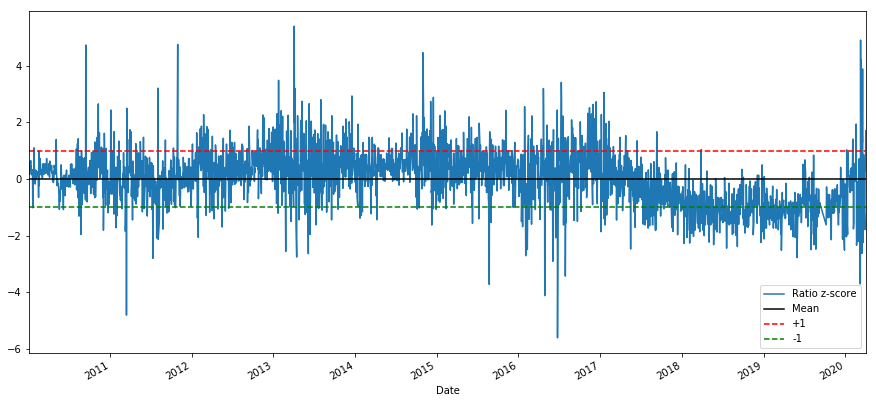

In [11]:
zscores = zscore(ratios)
zscores.plot(figsize=(15,7))
#print(zscores)
plt.axhline(zscore(ratios).mean(), color='black')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.legend(['Ratio z-score', 'Mean', '+1', '-1'])
plt.show()

# Variables

In [80]:
# Indicators
moving_avg_1 = 40 #default 60
moving_avg_2 = 2 # default 5
macd_fast = 1
macd_slow = 2

# Trading limits
limit = 0.5 #default 1
exit_limit = 0.3 #default -.75
leverage_limit = 1
max_leverage = 10
vol_limit = 0.004
vol_interval = 15


# Identify features
- Slow Moving Average of Ratio: Check Variables
- Fast Moving Average of Ratio: Check Variables
- Standard Deviation (Based on Slow Moving AVG) 
- z score: (FastMA — SlowMA) / STD
- macd

### ZScore

In [57]:
moving_avg_fast = ratios.rolling(window=moving_avg_2,
                               center=False).mean()
moving_avg_slow = ratios.rolling(window=moving_avg_1,
                               center=False).mean()
std_60 = ratios.rolling(window=moving_avg_1,
                        center=False).std()
zscore_moving_avg = (moving_avg_fast - moving_avg_slow)/std_60
plt.figure(figsize=(15,7))


fig = go.Figure()

#print(macd_low)
fig.add_trace(go.Scatter(x=ratios.index, y=ratios,
                    mode='lines',
                    name='ratio'))

fig.add_trace(go.Scatter(x=moving_avg_fast.index, y=moving_avg_fast,
                    mode='lines',
                    name='MA_Fast'))

fig.add_trace(go.Scatter(x=moving_avg_slow.index, y=moving_avg_slow,
                    mode='lines',
                    name='MA_Slow'))


fig.show()

<Figure size 1080x504 with 0 Axes>

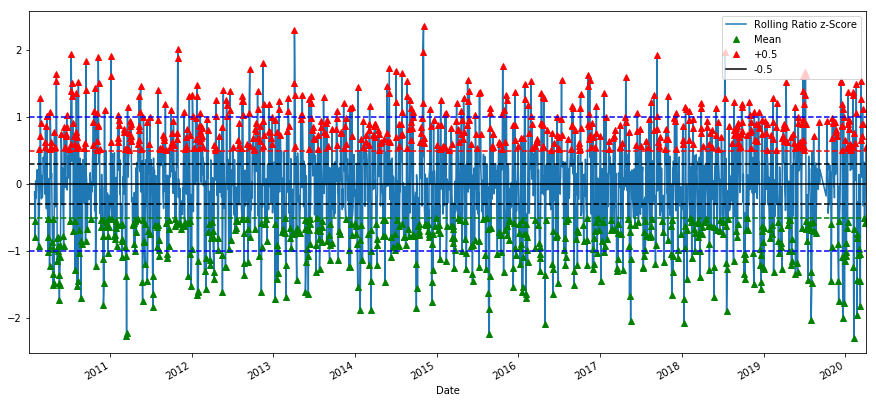

In [58]:
plt.figure(figsize=(15,7))
zscore_moving_avg.plot()

#buy_with_leverage = zscore_moving_avg.copy()
#buy_with_leverage[zscore_moving_avg>-leverage_limit] = None

#sell_with_leverage = zscore_moving_avg.copy()
#sell_with_leverage[zscore_moving_avg<leverage_limit] = None

buy = zscore_moving_avg.copy()
buy[zscore_moving_avg>-limit] = None

sell = zscore_moving_avg.copy()
sell[zscore_moving_avg<limit] = None

buy.plot(color='g', linestyle='None', marker='^')
sell.plot(color='r', linestyle='None', marker='^')


#buy_with_leverage.plot(color='black', linestyle='None', marker='^')
#sell_with_leverage.plot(color='black', linestyle='None', marker='^')

plt.axhline(0, color='black')
plt.axhline(limit, color='red', linestyle='--')
plt.axhline(-limit, color='green', linestyle='--')
plt.axhline(leverage_limit, color='blue', linestyle='--')
plt.axhline(-leverage_limit, color='blue', linestyle='--')
plt.axhline(exit_limit, color='black', linestyle='--')
plt.axhline(-exit_limit, color='black', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+'+str(limit), '-'+str(limit)])
plt.show()

In [59]:

fig = go.Figure()

#print(macd_low)
fig.add_trace(go.Scatter(x=zscore_moving_avg.index, y=zscore_moving_avg,
                    mode='lines',
                    name='ratio'))

fig.add_trace(go.Scatter(x=buy.index, y=buy,
                    mode='lines',
                    name='Buy'))

fig.add_trace(go.Scatter(x=sell.index, y=sell,
                    mode='lines',
                    name='Sell'))


fig.show()

### MACD

In [60]:
zscores_frame = zscore_moving_avg.to_frame()
#print(zscores_frame)
macd_high = zscore_moving_avg.ewm(span=macd_fast, adjust=False).mean()
macd_low = zscore_moving_avg.ewm(span=macd_slow, adjust=False).mean()
#macd_high = exp1-exp2
#macd_low = macd.ewm(span=9, adjust=False).mean()


plt.figure(figsize=(15,7))
fig = go.Figure()

#print(macd_low)
fig.add_trace(go.Scatter(x=macd_high.index, y=macd_high,
                    mode='lines',
                    name='high'))

fig.add_trace(go.Scatter(x=macd_low.index, y=macd_low,
                    mode='lines',
                    name='low'))



fig.show()

<Figure size 1080x504 with 0 Axes>

### Cointegration

### Volatility

In [61]:
ratios_vol = pd.DataFrame(index=ratios.index, columns=['Vol'])
limit_line = pd.DataFrame(index=ratios.index, columns=['Limit'], data=len(ratios)*[vol_limit])
#print(ratios_vol)

interval = vol_interval
for i in range(interval, len(S1)):
    date = ratios.index[i]
    r = ratios[i-interval : i]
    vol = r.std()
    ratios_vol.loc[date]['Vol'] = vol

plt.figure(figsize=(20,7))
fig = go.Figure()

#print(macd_low)
fig.add_trace(go.Scatter(x=ratios_vol.index, y=ratios_vol['Vol'],
                    mode='lines',
                    name='Vol'))
fig.add_trace(go.Scatter(x=limit_line.index, y=limit_line['Limit'],
                    mode='lines',
                    name='Limit'))

fig.show()

<Figure size 1440x504 with 0 Axes>

## Trading algo

In [62]:
def get_holding_return_on_close(holding):
    if holding['type'] == 'BUY':
        holding['return'] = (holding['sold_at'] / holding['bought_at'] -1) * holding['leverage']
    else:
        holding['return'] = (1 - holding['sold_at'] / holding['bought_at'])  * holding['leverage']
    holding['nav'] = holding['amount'] + (holding['return'] * holding['amount'])
    return holding


In [76]:
def get_open_holding_nav(holding, current_price):
    if holding['type'] == 'BUY':
        holding['return'] = (current_price / holding['bought_at'] -1) * holding['leverage']
    else:
        holding['return'] = (1 - current_price / holding['bought_at']) * holding['leverage']
    holding['nav'] = holding['amount'] + (holding['return'] * holding['amount'])
    return holding['nav']

In [81]:
# Trade using a simple strategy
# If window length is 0, algorithm doesn't make sense, so exit
def trade(S1, S2):
    portfolio = {
        'cash': 10000,
        'nav': 10000,
        'holdings': {
            's1': None,
            's2': None
        },
        'history': pd.DataFrame(columns=["symbol", "type", "amount", "bought_at", "bought_on", "status"]),
        'nav': pd.DataFrame(columns=['date', 'nav'])
    }
    prices = pd.DataFrame(columns=["Date", "Action", "Price"])
    
    old_trend = ""
    new_trend = ""
    indicator = zscore_moving_avg
    for i in range(len(indicator)):
        date = indicator.index[i]
        #print(ratios_vol.loc[date])
        within_vol = not math.isnan(ratios_vol.loc[date]['Vol']) and ratios_vol.loc[date]['Vol'] < vol_limit
        
        if macd_low[date] <= macd_high[date]:
            new_trend = "UP"
        else:
            new_trend = "DOWN"
            
       # dates.append
        # Sell short if the z-score is > 1
        if indicator[i] > limit and new_trend == "DOWN" and within_vol:
            if portfolio['holdings']['s1'] == None and portfolio['holdings']['s2'] == None:
                amount = portfolio['cash'] * 0.5
                leverage = 1
                if indicator[i] > leverage_limit:
                    leverage = max_leverage
                    
                portfolio['holdings']['s1'] = {'amount': amount, 'bought_at': S1.loc[indicator.index[i]], 'type': 'SELL', 'bought_on': indicator.index[i], 'symbol': chosen[0], 'status': 'OPEN', 'leverage': leverage}
                portfolio['holdings']['s2'] = {'amount': amount, 'bought_at': S2.loc[indicator.index[i]], 'type': 'BUY', 'bought_on': indicator.index[i], 'symbol': chosen[1], 'status': 'OPEN', 'leverage': leverage}
                portfolio['cash'] = portfolio['cash'] - amount*2
                
        # Buy long if the z-score is < 1
        elif indicator[i] < -limit and new_trend == "UP" and within_vol:
            if portfolio['holdings']['s1'] == None and portfolio['holdings']['s2'] == None:
                amount = portfolio['cash'] * 0.5
                leverage = 1
                if indicator[i] < -leverage_limit:
                    leverage = max_leverage
                    
                portfolio['holdings']['s1'] = {'amount': amount, 'bought_at': S1.loc[indicator.index[i]], 'type': 'BUY', 'bought_on': indicator.index[i], 'symbol': chosen[0], 'status': 'OPEN', 'leverage': leverage}
                portfolio['holdings']['s2'] = {'amount': amount, 'bought_at': S2.loc[indicator.index[i]], 'type': 'SELL', 'bought_on': indicator.index[i], 'symbol': chosen[1], 'status': 'OPEN', 'leverage': leverage}
                portfolio['cash'] = portfolio['cash'] - amount*2
        
        # Clear positions if the z-score between -.5 and .5
        elif abs(indicator[i]) < exit_limit or not within_vol:
            if portfolio['holdings']['s1'] != None and portfolio['holdings']['s2'] != None:
                s1_res =  portfolio['holdings']['s1']
                s1_res['sold_on'] =  indicator.index[i]
                s1_res['sold_at'] =  S1.loc[indicator.index[i]]
                s1_res['status'] = 'CLOSE'
                s1_res = get_holding_return_on_close(s1_res)
                
                s2_res =  portfolio['holdings']['s2']
                s2_res['sold_on'] =  indicator.index[i]
                s2_res['sold_at'] =  S2.loc[indicator.index[i]]
                s2_res['status'] = 'CLOSE'
                s2_res = get_holding_return_on_close(s2_res)

                portfolio['cash'] = s1_res['nav'] + s2_res['nav']
                
                portfolio['nav'] = portfolio['nav'].append({'date': indicator.index[i], 'nav': portfolio['cash']}, ignore_index=True)

                portfolio['history'] = portfolio['history'].append(s1_res, ignore_index=True)
                portfolio['history'] = portfolio['history'].append(s2_res, ignore_index=True)

                portfolio['holdings']['s1'] = None
                portfolio['holdings']['s2'] = None

                #print('Exit')
        
        holdings_nav = 0
        if portfolio['holdings']['s1'] != None and portfolio['holdings']['s2'] != None:
            s1_nav = get_open_holding_nav(portfolio['holdings']['s1'], S1.loc[indicator.index[i]])
            s2_nav = get_open_holding_nav(portfolio['holdings']['s2'], S2.loc[indicator.index[i]])
            holdings_nav = s1_nav + s2_nav

        portfolio['nav'] = portfolio['nav'].append({'date': indicator.index[i], 'nav': portfolio['cash'] + holdings_nav}, ignore_index=True)
        
        old_trend = new_trend
        #print(portfolio['history'])
            
            #print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))
    
    portfolio['nav'] = portfolio['nav'].set_index('date')
    return portfolio

portfolio = trade(quotes[chosen[0]],quotes[chosen[1]])



In [82]:
normalized_nav = pd.DataFrame(portfolio['nav'])
normalized_nav = normalized_nav.reset_index()
normalized_nav['nav'] = normalized_nav['nav'] / normalized_nav['nav'].iloc[0]
normalized_nav = normalized_nav.set_index('date')

returns = np.log(portfolio['nav'] / portfolio['nav'].shift(1))
vol = returns.std() * 250 ** 0.5
print(vol)

#print(portfolio['nav'].std() * np.sqrt(252) )

nav    0.071641
dtype: float64


In [83]:
normalized_S1 = S1.apply(lambda x: x / S1[0])
normalized_S2 = S2.apply(lambda x: x / S2[0])
normalized_nav = pd.DataFrame(portfolio['nav'])
normalized_nav = normalized_nav.reset_index()
normalized_nav['nav'] = normalized_nav['nav'] / normalized_nav['nav'].iloc[0]
normalized_nav = normalized_nav.set_index('date')


fig = go.Figure()
fig.add_trace(go.Scatter(x=normalized_S1.index, y=normalized_S1,
                    mode='lines',
                    name=chosen[0]))

fig.add_trace(go.Scatter(x=normalized_S2.index, y=normalized_S2,
                    mode='lines',
                    name=chosen[1]))
fig.add_trace(go.Scatter(x=normalized_nav.index, y=normalized_nav['nav'],
                    mode='lines',
                    name='strategy'))

fig.show()


In [74]:
nav = ratios.to_frame()
#print(nav)
history = portfolio['history']

history = history[history['symbol'] == chosen[0]]
trades = pd.DataFrame(columns=["Type" "BoughtOn", "SoldOn", "Return"])
trades['Type'] = history["type"]
trades['BoughtOn'] = history['bought_on']
trades['SoldOn'] = history['sold_on']
trades['Return'] = history['return']

bought_on = trades['BoughtOn'].to_frame()
bought_on['Type'] = trades['Type']
bought_on.columns = ['date', 'type']
bought_on.set_index('date', inplace=True)
nav = nav.join(bought_on)

sold_on = trades['SoldOn'].to_frame()
sold_on['exit'] = "Exit"
sold_on.columns = ['date', 'exit']
sold_on['exit'] = "Exit"
sold_on.set_index('date', inplace=True)

bought = nav[nav['type'] == 'BUY']
sold_on = nav[nav['type'] == 'SELL']


In [68]:
def plot_returns(ret):
    #tot_return['date'] = pd.to_datetime(tot_return.index)
    fig = px.line(ret, x=ret.index, y='nav')
    fig.show()


In [69]:
plot_returns(portfolio['nav'])

In [27]:
new_ratios = zscore_moving_avg.to_frame()
#print(new_zscores)
history = portfolio['history']

history = history[history['symbol'] == chosen[1]]
trades = pd.DataFrame(columns=["Type" "BoughtOn", "SoldOn", "Return"])
trades['Type'] = history["type"]
trades['BoughtOn'] = history['bought_on']
trades['SoldOn'] = history['sold_on']
trades['Return'] = history['return']

bought_on = trades['BoughtOn'].to_frame()
bought_on['Type'] = trades['Type']
bought_on.columns = ['Date', 'Type']
bought_on.set_index('Date', inplace=True)
new_ratios = new_ratios.join(bought_on)

sold_on = trades['SoldOn'].to_frame()
sold_on['exit'] = "Exit"
sold_on.columns = ['Date', 'exit']
sold_on['Exit'] = "EXIT"
sold_on.set_index('Date', inplace=True)
new_ratios = new_ratios.join(sold_on)

bought_zscore = new_ratios[new_ratios['Type'] == 'BUY']
sold_zscore = new_ratios[new_ratios['Type'] == 'SELL']
exit_zscore =  new_ratios[new_ratios['Exit'] == 'EXIT']
#print(sold_zscore)
#print(new_zscores.loc['2010-09-20'])

In [583]:
plt.figure(figsize=(15,7))

#print(bought_zscore)
#print(new_zscores)
fig = go.Figure()
fig.add_trace(go.Scatter(x=new_ratios.index, y=new_ratios[0],
                    mode='lines',
                    name='ratios'))

fig.add_trace(go.Scatter(x=bought_zscore.index, y=bought_zscore[0],
                    mode='markers',
                    name='sell'))

fig.add_trace(go.Scatter(x=sold_zscore.index, y=sold_zscore[0],
                    mode='markers',
                    name='buy'))

fig.add_trace(go.Scatter(x=exit_zscore.index, y=exit_zscore[0],
                    mode='markers',
                    name='exit'))
fig.show()

<Figure size 1080x504 with 0 Axes>

In [585]:
print(portfolio['history'])

           symbol  type       amount  bought_at  bought_on status  leverage  \
0    JPYAED.FOREX   BUY  5000.000000     0.0406 2010-02-02  CLOSE       1.0   
1    JPYHKD.FOREX  SELL  5000.000000     0.0859 2010-02-02  CLOSE       1.0   
2    JPYAED.FOREX  SELL  5002.236533     0.0413 2010-02-25  CLOSE       1.0   
3    JPYHKD.FOREX   BUY  5002.236533     0.0872 2010-02-25  CLOSE       1.0   
4    JPYAED.FOREX   BUY  5008.292510     0.0391 2010-04-01  CLOSE       1.0   
5    JPYHKD.FOREX  SELL  5008.292510     0.0827 2010-04-01  CLOSE       1.0   
6    JPYAED.FOREX  SELL  5013.651507     0.0394 2010-04-12  CLOSE       1.0   
7    JPYHKD.FOREX   BUY  5013.651507     0.0832 2010-04-12  CLOSE       1.0   
8    JPYAED.FOREX   BUY  5016.664519     0.0393 2010-04-22  CLOSE       1.0   
9    JPYHKD.FOREX  SELL  5016.664519     0.0831 2010-04-22  CLOSE       1.0   
10   JPYAED.FOREX   BUY  5020.374217     0.0408 2010-05-21  CLOSE      10.0   
11   JPYHKD.FOREX  SELL  5020.374217     0.0867 2010